Here are the libraries to be installed before using this code. Use `pip install` to install the following libraries: <br>
```
biopython
matplotlib
playwright
```

In [1]:
from Bio import PDB
import time
import scipy
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import csv

This function downloads the conservation score of a specific pdb file using __[Consurf Database](https://consurfdb.tau.ac.il/)__. <br>

Input: `pdb_file_path`, `chain_id` (e.g. A, B, C, D) and `protein_id` (e.g. 2PE4)<br>
Output: Folder named "<protein_id>_conservation_scores." Each conservation score file is named with its respective PDB ID.

In [2]:
import asyncio
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_paths, protein_id, molecular_name):
    """
    Downloads conservation score from Consurf Database using specific PDB file

    Input:
    - pdb_file_paths (list of str): List of PDB file paths
    - protein_id (str): Protein ID
    - molecular_name (str): Molecular name to extract chain IDs

    Output:
    - Folder with conservation score in txt format, file named with PDB ID 
    """
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_paths if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir = f"{protein_id}_outputs/{protein_id}_conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}{chain}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_file in pdb_file_paths:
            pdb_id = re.search(pattern, pdb_file).group(1).upper()
            chain_ids = extract_chain_ids(pdb_file, molecular_name)
            print(f"Chain IDs for {pdb_id}: {chain_ids}")
            for chain in chain_ids:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_file, result in zip(pdb_file_paths, results):
            pdb_id = re.search(pattern, pdb_file).group(1).upper()
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

This function extracts the conservation scores from the downloaded conservation score files and saves the extracted scores as a list, each list item contains 3 dict objects: <i>residue_id</i>, <i>residue_name</i> and <i>conservation_score</i>. <br>

Input: `filename`, `chain_id` <br>
Output: List of dictionaries with residue information and conservation score

In [3]:
def extract_conservation_score(filename, chain_id):
    """
    Extracts conservation scores from a file, considering the specific chain ID.

    Parameters:
    - filename (str): Path to the conservation score file
    - chain_id (str): Chain ID for the PDB file

    Returns:
    - List of dictionaries with residue information and conservation scores
    """
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({
                            'residue_id': residue_id,
                            'residue_name': residue_name,
                            'conservation_score': score,
                            'chain_id': chain_id
                        })

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None


This function extracts chain ids from a PDB file that correspond to a given molecular name. <br>

Input: `pdb_file` String, PDB file path, `molecular_name` String, molecular name to search for in PDB file <br>
Output: `chain_ids_list` List of chain IDs that contain molecular name


In [4]:
def extract_chain_ids(pdb_file, molecular_name):
    """
    Extracts chain ids from a PDB file that correspond to a given molecular name.
    
    Parameters:
    - pdb_file (str): Path to the PDB file.
    - molecular_name (str): Molecular name to search for in the PDB file.
    
    Returns:
    - List of chain IDs containing the specified molecular name.
    """
    chain_ids = set()  # Use a set to automatically handle duplicates
    with open(pdb_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if molecular_name in line:
                # The line immediately after contains chain IDs
                if i + 1 < len(lines):
                    chain_line = lines[i + 1]
                    if "CHAIN:" in chain_line:
                        # Strip whitespace and semicolons, then split by commas
                        ids = chain_line.split("CHAIN:")[1].strip().strip(';').split(',')
                        chain_ids.update(id.strip(';').strip() for id in ids)
    chain_ids_list = list(chain_ids)
    # print(f"Extracted chain IDs for {molecular_name} in {pdb_file}: {chain_ids_list}")
    return chain_ids_list

This function reads a PDB file and extracts the 3D spacial coordinates and amino acids.<br>

Input: `pdb_file_path` String, PDB file path<br>
Output: `atom_info_list` A list of dictionaries, each dictionary containing information about each atom

In [5]:
def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids,
    applying residue ID corrections based on DBREF entries if available.

    Input:
    - pdb_file_path (str): Path to the PDB file

    Output:
    - atom_info_list: A list of dictionaries, each containing information about each atom
    - chain_offsets: Dictionary with chain IDs as keys and residue ID offsets as values
    """
    # Create a PDBParser object
    parser = PDB.PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # Dictionary to hold chain offsets from DBREF entries
    chain_offsets = {}

    # Read the PDB file line by line to find DBREF entries
    with open(pdb_file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith("DBREF"):
                parts = line.split()
                chain_id = parts[2]
                start_residue_pdb = int(parts[3])
                start_residue_db = int(parts[8])
                # Calculate offset
                offset = start_residue_db - start_residue_pdb
                chain_offsets[chain_id] = offset

    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            offset = chain_offsets.get(chain.id, 0)  # Default offset is 0 if not found
            for residue in chain:
                for atom in residue:
                    # Apply offset to the residue ID
                    corrected_residue_id = residue.id[1] + offset
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': corrected_residue_id,
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)
    # print(chain_offsets)

    return atom_info_list, chain_offsets


This function aligns sequences from the reference and PDB sequences based on residue IDs, and sorts the columns by chain ID for each PDB file. <br>

Input: `ref_seq`, `pdb_sequences` <br>
Output: Pandas DataFrame with aligned sequences, columns sorted alphabetically by chain ID

In [6]:
def align_sequences(ref_seq, pdb_sequences):
    """
    Aligns sequences from the reference and PDB sequences based on residue IDs,
    and sorts the columns by chain ID for each PDB file.

    Parameters:
    - ref_seq (list of dicts): Reference sequence residues.
    - pdb_sequences (dict): Dictionary with PDB sequence titles and chain residues.

    Returns:
    - Pandas DataFrame with aligned sequences, with columns sorted alphabetically by chain ID.
    """
    # Extract residue IDs from the reference sequence
    ref_residue_ids = [residue['residue_id'] for residue in ref_seq]

    # Initialize the DataFrame with the reference sequence
    df = pd.DataFrame(ref_residue_ids, columns=['residue_id'])
    df['ref_seq'] = [residue['residue_name'] for residue in ref_seq]

    # Collect columns to be added to DataFrame
    columns_to_add = []

    # Align each PDB sequence to the reference sequence
    for pdb_title, chain_residues in pdb_sequences.items():
        for chain_id, residues in chain_residues.items():
            pdb_dict = {res['residue_id']: res['residue_name'] for res in residues}
            column_name = f"{pdb_title}_{chain_id}"
            df[column_name] = df['residue_id'].apply(lambda x: pdb_dict.get(x, '-'))
            columns_to_add.append(column_name)

    # Sort columns alphabetically, keeping 'residue_id' and 'ref_seq' at the beginning
    sorted_columns = sorted(columns_to_add)
    sorted_columns = ['residue_id', 'ref_seq'] + sorted_columns
    df = df[sorted_columns]

    return df


This function aligns and compares sequences from the reference and PDB files, without handling offsets and outputs a csv with aligned sequences.(since extract_pdb_info already handles offsets). <br>

Input: `ref_seq` String, reference sequence file path, `pdb_file_paths` List of pdb file paths, `molecular_name` <br>
Output: Pandas DataFrame with aligned sequences.

In [7]:
def align_pdb(ref_seq, pdb_file_paths, protein_id, molecular_name):
    """
    Aligns and compares sequences from the reference and PDB files, without handling offsets (since extract_pdb_info already handles offsets).

    Parameters:
    - ref_seq (str): Path to the reference PDB file.
    - pdb_file_paths (list of str): List of PDB file paths to compare.
    - molecular_name (str): Molecular name to search for chain IDs.

    Returns:
    - Pandas DataFrame with aligned sequences.
    """
    # Extract chain IDs and residue info from the reference sequence
    ref_atoms, ref_chain_offsets = extract_pdb_info(ref_seq)

    ref_chain_ids = extract_chain_ids(ref_seq, molecular_name)
    ref_residues = [
        {
            'residue_id': atom['residue_id'],
            'residue_name': atom['residue_name']
        }
        for atom in ref_atoms
        if atom['atom_name'] == 'CA'
    ]
    
    if len(ref_residues) == 0:
        raise ValueError("No residues extracted from reference sequence. Please check the PDB file and chain IDs.")

    # Extract residue information from each PDB file
    pdb_sequences = {}
    for pdb_file in pdb_file_paths:
        pdb_title = os.path.basename(pdb_file).replace('.pdb', '')
        chain_ids = extract_chain_ids(pdb_file, molecular_name)
        
        # Extract atom info from PDB
        pdb_atoms, pdb_chain_offsets = extract_pdb_info(pdb_file)

        # Do not adjust residue IDs based on offsets
        chain_residues = {}
        for chain_id in chain_ids:
            residues = [
                {
                    'residue_id': atom['residue_id'],
                    'residue_name': atom['residue_name']
                }
                for atom in pdb_atoms
                if atom['atom_name'] == 'CA' and atom['chain_id'] == chain_id
            ]
            chain_residues[chain_id] = residues
        
        pdb_sequences[pdb_title] = chain_residues

    # Align the sequences
    df = align_sequences(ref_residues, pdb_sequences)
    
    # Output the DataFrame to a CSV file (optional)
    output_file = os.path.join(f'{protein_id}_outputs', f'{protein_id}_aligned_sequences.csv')
    df.to_csv(output_file, index=False)
    print(f"Aligned sequences have been written to {output_file}")

    return df


This function extracts binding site information from a list of PDB files. <br>

Input: `pdb_file_paths` List of PDB file paths<br>
Output: `binding_sites` Dictionary where keys are (`residue_id`, `residue_name`) and values are comma-separated pdb_ids with chain_ids

In [8]:
def extract_sites(pdb_file_paths):
    """
    Extract binding site information from multiple PDB files.

    Parameters:
    - pdb_file_paths (list of str): List of PDB file paths to extract binding site information from.

    Returns:
    - binding_sites (dict): Dictionary where keys are (residue_id, residue_name) and values are comma-separated pdb_ids with chain_ids
    """
    binding_sites = {}


    for pdb_file_path in pdb_file_paths:
        pdb_id = os.path.basename(pdb_file_path).replace('.pdb', '')
        
        # Read the PDB file line by line to find DBREF entries
        with open(pdb_file_path, 'r') as pdb_file:
            for line in pdb_file:
                if line.startswith("DBREF"):
                    parts = line.split()
                    chain_id = parts[2]
                    start_residue_pdb = int(parts[3])
                    start_residue_db = int(parts[8])
                    # Calculate offset
                    offset = start_residue_db - start_residue_pdb

                if line.startswith('SITE'):
                    fields = line.split()
                    for i in range(4, len(fields), 3):  # Starting from index 4 and skipping by 3
                        if i + 2 < len(fields):  # Ensure there are enough fields
                            residue_name = fields[i]
                            chain_id = fields[i + 1]
                            residue_id_str = fields[i + 2]
                            
                            # Check if the residue_id is numeric and skip non-numeric ones
                            if residue_id_str.isdigit():
                                residue_id = int(residue_id_str)+offset
                                key = (residue_id, residue_name)
                                
                                if key in binding_sites:
                                    binding_sites[key].append(f"{pdb_id}_{chain_id}")
                                else:
                                    binding_sites[key] = [f"{pdb_id}_{chain_id}"]

    # Convert lists of pdb_ids to comma-separated strings
    for key in binding_sites:
        binding_sites[key] = ', '.join(binding_sites[key])

    return binding_sites


This function finds the N-neighbours closest to the Alpha Carbon atoms, using brute force with Euclidean distance. It counts the number of neighbours and also collects the `residue_id` of its neighbours<br>

Input: `data` List of dictionaries, `angstrom` Float, Distance threshold for neighbour counting <br>
Output: `data` List of dictionaries, containing only 'CA' atoms with `neighbour_count` and `neighbours` field and without `model_id`, `atom_name` and `atom_coords` keys

In [9]:
def find_nearest_neighbours(data, angstrom, chain_ids):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Input:
    - data: list of dictionaries, each containing atom information
    - angstrom (float): distance threshold for neighbour counting
    - chain_ids: list of chain IDs to include in the neighbor search

    Output:
    - ca_atoms_neighbour: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """

    # Filter data to only include 'CA' atoms in the specified chain_ids
    chain_ca_atoms = {}
    for atom in data:
        chain_id = atom.get('chain_id')
        if chain_id in chain_ids and atom.get('atom_name') == 'CA':
            if chain_id not in chain_ca_atoms:
                chain_ca_atoms[chain_id] = []
            chain_ca_atoms[chain_id].append(atom)

    all_ca_atoms_neighbour = []
    
    for chain_id, ca_atoms in chain_ca_atoms.items():
        # Extract and verify coordinates
        ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])
        
        # Calculate distances between 'CA' atoms
        distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')
        
        # Use 'residue_id' for DataFrame indexing
        residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
        
        # Convert distance matrix to pandas DataFrame
        distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)
        
        # Format distance matrix to 3 decimal places
        distance_df = distance_df.round(3)

        # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
        for index, ca_point in enumerate(ca_coords):
            neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
            ca_atoms[index]['neighbour_count'] = neighbour_count
            
            neighbour_ids = distance_df.columns[(distances[index] <= angstrom) & (distances[index] != 0)].tolist()
            ca_atoms[index]['neighbours'] = neighbour_ids

        
        # Remove specified keys from the 'CA' atoms
        keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
        for atom in ca_atoms:
            for key in keys_to_remove:
                atom.pop(key, None)
        
        # Add chain ID to each atom dictionary
        for atom in ca_atoms:
            atom['chain_id'] = chain_id
        
        all_ca_atoms_neighbour.extend(ca_atoms)
    # print(all_ca_atoms_neighbour)
    return all_ca_atoms_neighbour


This function finds the hydrophobicity of the amino acid. Hydrophobicity values are taken from the __[IMGT Scale](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/abbreviation.html)__.<br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `hydrophobicity` information

In [10]:
def find_hydrophobicity(aa_residue):
    """
    Assign hydrophobicity values to an amino acid, using IMGT Scale

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'hydrophobicity' key
    """
    hydrophobicity_scale = {"ALA": 1.8, "ARG": -4.5, "ASN": -3.5, "ASP": -3.5, "CYS": 2.5, "GLN": -3.5, "GLU": -3.5,
            "GLY": -0.4, "HIS": -3.2, "ILE": 4.5, "LEU": 3.8, "LYS": -3.9, "MET": 1.9, "PHE": 2.8,
            "PRO": -1.6, "SER": -0.8, "THR": -0.7, "TRP": -0.9, "TYR": -1.3, "VAL": 4.2}
        
    if aa_residue["residue_name"] in hydrophobicity_scale:
        aa_residue['hydrophobicity'] = hydrophobicity_scale[aa_residue["residue_name"]]
    else:
        aa_residue['hydrophobicity'] = None
    
    return aa_residue

This function finds the volume of the amino acid. Volume information is taken from the __[IMGT Scale](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/abbreviation.html)__.<br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `volume` information

In [11]:
def find_volume(aa_residue):
    """
    Assign volume to an amino acid, using IMGT Scale

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'volume' key
    """
    volume_scale = {"ALA": 88.6, "ARG": 173.4, "ASN": 114.1, "ASP": 111.1, "CYS": 108.5, "GLN": 143.8, "GLU": 138.4,
            "GLY": 60.4, "HIS": 153.2, "ILE": 166.7, "LEU": 166.7, "LYS": 168.6, "MET": 162.9, "PHE": 189.9,
            "PRO": 112.7, "SER": 89.0, "THR": 116.1, "TRP": 227.8, "TYR": 193.6, "VAL": 140.0}
        
    if aa_residue['residue_name'] in volume_scale:
        aa_residue['volume'] = volume_scale[aa_residue['residue_name']]
    else:
        aa_residue['volume'] = None
    
    return aa_residue

This function classifies the proton accepting & donating ability of the amino acids. Amino acids that are non-donors and non-acceptors are given a value of 0, Either Donor or Acceptor is given a value of 1 and Both Donor and Acceptor are given a value of 2.5. Ref from: __[IMGT](https://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/charge/index.html#hydrogen)__ <br>

Input: `aa_residue` Dictionary containing `residue_name`<br>
Output: `aa_residue` Dictionary with corresponding `proton_donor` information

In [12]:
def find_proton_donor(aa_residue):
    """
    Classifies amino acid based on proton accepting/donating ability

    Input:
    - aa_residue: Dict object with 'residue_name'

    Ouput:
    - aa_residue: Dict object with 'proton_donor' key
    """
    # Protons donor given 1, Protons acceptors given 1, Both donor and acceptor given 2.5, Neither donor nor receiver given 0
    proton_scale = {"ALA": 0, "ARG": 1, "ASN": 2.5, "ASP": 1, "CYS": 0, "GLN": 2.5, "GLU": 1,
            "GLY": 0, "HIS": 2.5, "ILE": 0, "LEU": 0, "LYS": 1, "MET": 0, "PHE": 0,
            "PRO": 0, "SER": 2.5, "THR": 2.5, "TRP": 1, "TYR": 2.5, "VAL": 0}
        
    if aa_residue['residue_name'] in proton_scale:
        aa_residue['proton_donor'] = proton_scale[aa_residue['residue_name']]
    else:
        aa_residue['proton_donor'] = None
    
    return aa_residue

This function merges the `neighbour_count` and `conservation_score` information. It then calls the `find_hydrophobicity`, `find_volume` and `find_proton_donor` functions to assign the respective information to each residue. <br>

Input: `conservation_scores` List of Dictionaries with Conservation Score, `neighbour_counts` List of Dictionaries with Neighbour Count. `chain_ids`, `chain_offsets`<br>
Output: `merged_data` List of Dictionaries with `residue_id`, `residue_name`, `conservation_score`, `neighbour_count`, `neighbours`, `hydrophobicity`, `volume` and `proton_donor`.

In [13]:
def merge_residue_data(conservation_scores, neighbour_counts, chain_id, chain_offsets):
    """
    Merges conservation score and neighbour count, then assigns hydrophobicity, volume and proton donor/acceptor
    considering the DBREF displacement for conservation scores only.

    Input:
    - conservation_scores: List of dictionaries with conservation score
    - neighbour_counts: List of dictionaries with neighbour count
    - chain_id: The chain ID to differentiate between chains
    - chain_offsets: Dictionary with chain IDs as keys and residue ID offsets as values

    Output:
    - merged_data: List of dictionaries with residue id, residue name, conservation score, neighbour count, neighbours, hydrophobicity, volume and proton donor/acceptor
    """
    # Create dictionaries to index the data by residue_id, residue_name, and chain_id
    neighbour_dict = {
        (item['residue_id'], item['residue_name'], item['chain_id']): item
        for item in neighbour_counts
    }
    conservation_dict = {
        (item['residue_id'], item['residue_name'], item['chain_id']): item
        for item in conservation_scores
    }

    # Determine all unique residue identifiers, including chain_id
    all_residues = set(neighbour_dict.keys()).union(conservation_dict.keys())

    # List to hold merged data
    merged_data = []

    # Get the displacement (offset) for the current chain_id
    displacement = chain_offsets.get(chain_id, 0)

    # Merge data from conservation_scores with neighbour_counts
    for residue_id, residue_name, chain in all_residues:
        # Adjust residue ID for conservation scores based on displacement
        adjusted_residue_id = residue_id + displacement if (residue_id, residue_name, chain) in conservation_dict else residue_id

        # Create a dictionary entry for the residue
        merged_entry = {
            'residue_id': adjusted_residue_id,
            'residue_name': residue_name,
            'chain_id': chain,
            'conservation_score': conservation_dict.get((residue_id, residue_name, chain), {}).get('conservation_score', None),
            'neighbour_count': neighbour_dict.get((residue_id, residue_name, chain), {}).get('neighbour_count', None),
            'neighbours': neighbour_dict.get((residue_id, residue_name, chain), {}).get('neighbours')
        }
        
        # Add additional attributes
        find_hydrophobicity(merged_entry)
        find_volume(merged_entry)
        find_proton_donor(merged_entry)

        # Append to the merged data list
        merged_data.append(merged_entry)
    
    # Sort the merged data by chain_id and residue_id
    merged_data.sort(key=lambda x: (x['chain_id'], x['residue_id']))

    return merged_data


This function calls `extract_pdb_info`, `find_nearest_neighbors`. `extract_conservation_score` and `merge_residue_data`<br>

Input: `pdb_file_path`, `angstrom`, `protein_id`<br>
Ouput: `merged_data` with all the parameters

In [14]:
def pdb_to_compiled_vector(pdb_file_path, angstrom, protein_id, molecular_name):
    """
    For each pdb sequence, outputs the combined data with all 5 parameters

    Input:
    - pdb_file_path (str): Path to the PDB file
    - angstrom: float, distance threshold for neighbour counting
    - protein_id (str): Protein ID
    - molecular_name (str): Protein name

    Output:
    - merged_residues: List of dictionaries with residue id, residue name, conservation score, neighbour count, neighbours, hydrophobicity, volume, and proton donor/acceptor
    """
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    # Extract atom information and chain offsets
    atom_info_list, chain_offsets = extract_pdb_info(pdb_file_path)

    # Extract chain IDs from the PDB file
    chain_ids = extract_chain_ids(pdb_file_path, molecular_name)

    # Find the nearest neighbours
    neighbour_count = find_nearest_neighbours(atom_info_list, angstrom, chain_ids)
    
    print(f"Number of Amino Acids ({title}): {len(neighbour_count)}")
    
    merged_residues = []
    for chain_id in chain_ids:
        # Extract conservation scores for the current chain
        conservation_scores = extract_conservation_score(
            filename=f"{protein_id}_outputs/{protein_id}_conservation_scores/{title}{chain_id}_consurf_summary.txt",
            chain_id=chain_id
        )

        # Merge data for the current chain using chain_offsets
        if conservation_scores is not None:
            merged_residues = merge_residue_data(conservation_scores, neighbour_count, chain_id, chain_offsets)
        else:
            print(f"Conservation scores not found for {title} chain {chain_id}")
            merged_residues = merge_residue_data([], neighbour_count, chain_id, chain_offsets)

    return merged_residues


This function updates the consensus sequence with the information extracted from the PDB file. `neighbour_count`, `neighbours` and `conservation_score` fields are updated. <br>

Input: `ref_seq` Consensus Sequence from __(https://alphafold.ebi.ac.uk/)__ with complete sequence, `Completed` Processed pdb file to be updated to `ref_seq` <br>
Output: `updated_ref_seq`

In [15]:
def merge_to_ref_seq(ref_seq, completed, angstrom):
    """
    Updates consensus sequence with information extracted from the PDB file.

    Input:
    - ref_seq (list): List of dictionaries from the reference PDB sequence
    - completed (list): Processed PDB file data to be updated in ref_seq
    - angstrom (float): Distance threshold for neighbor counting

    Output:
    - updated_ref_seq: List of dictionaries
    """
    # Convert ref_seq to a dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry and entry['neighbour_count'] is not None:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
                ref_seq_entry['neighbours'] = entry['neighbours']
            if 'conservation_score' in entry and entry['conservation_score'] is not None:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            neighbour_count = entry.get('neighbour_count')

            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': neighbour_count,
                'conservation_score': entry.get('conservation_score'),
                'hydrophobicity': entry.get('hydrophobicity'),
                'volume': entry.get('volume'),
                'proton_donor': entry.get('proton_donor'),
                'neighbours': entry.get('neighbours')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())

    return updated_ref_seq


This function plots `neighbour_counts` and `conservation_scores` on the same plot, with `residue_id` as the x-axis. It also calculates the correlation between `neighbour_counts` and `conservation_scores`.

Input: `data` List of dictionaries of residues, `angstrom`, `protein_id`, `num_residues`<br>
Ouput: Scatter Plot containing `neighbour_counts` and `conservation_scores`

In [16]:
def plot_and_calculate_correlation(data, angstrom, protein_id, num_residues):
    """
    Plots neighbout count and conservation scores for all residues

    Input: 
    - data: List of dictionaries
    - angstrom
    - protein_id
    - num_residues

    Output:
    - scatter plot: y axes are neighbour count and conservation score, x axis is residue id
    - caculated correlation between neighbour counts and conservations scores
    """
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{protein_id} Complete: Residue ID vs Conservation Score and Neighbour Count ({angstrom}A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


This function plots the different parameters of individual residues as a horizontal bar chart. The x-axis is the `residue_id` and y-axis plots `hydrophobicity`, `neighbour_count`, `conservation_score`, `volume` and `proton_donor` values. A legend is provided below for identification. <br>

Input: `data` List of dictionaries containing residue properties, `protein_id`, `num_residues` <br>
Output: Summary Chart with the 5 parameters

In [17]:
def plot_residue_properties(data, protein_id, num_residues=None):
    # Limit the data to the specified number of residues
    if num_residues is not None:
        data = data[:num_residues]

    # Extract data for plotting and replace None with 0
    residue_ids = [entry['residue_id'] for entry in data]
    hydrophobicities = [entry.get('hydrophobicity', 0) or 0 for entry in data]
    conservation_scores = [entry.get('conservation_score', 0) or 0 for entry in data]
    neighbour_counts = [entry.get('neighbour_count', 0) or 0 for entry in data]
    volumes = [entry.get('volume', 0) or 0 for entry in data]
    proton_donors = [entry.get('proton_donor', 0) or 0 for entry in data]

    # Handle cases where lists might be empty
    min_hydrophobicity = min(hydrophobicities)
    max_hydrophobicity = max(hydrophobicities)
    min_conservation = min(conservation_scores)
    max_conservation = max(conservation_scores)
    min_neighbour = min(neighbour_counts)
    max_neighbour = max(neighbour_counts)
    min_volume = min(volumes)
    max_volume = max(volumes)
    min_proton = min(proton_donors)
    max_proton = max(proton_donors)

    norm_hydrophobicity = mcolors.Normalize(vmin=min_hydrophobicity, vmax=max_hydrophobicity)
    norm_conservation = mcolors.Normalize(vmin=min_conservation, vmax=max_conservation)
    norm_neighbour = mcolors.Normalize(vmin=min_neighbour, vmax=max_neighbour)
    norm_volume = mcolors.Normalize(vmin=min_volume, vmax=max_volume)
    norm_proton = mcolors.Normalize(vmin=min_proton, vmax=max_proton)


    cmap = plt.cm.coolwarm  # You can choose any colormap you prefer

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 3))

    # Set the title of the plot
    plt.title(f'Summary of {protein_id} Properties')

    # Plot proton donors/ acceptors 
    for i, proton_donor in enumerate(proton_donors):
        ax.barh(4.5, 1, left=i, color=cmap(norm_proton(proton_donor)), edgecolor='none', height=1)

    # Plot volume    
    for i, volume in enumerate(volumes):
        ax.barh(3.5, 1, left=i, color=cmap(norm_volume(volume)), edgecolor='none', height=1)

    # Plot hydrophobicity    
    for i, hydrophobicity in enumerate(hydrophobicities):
        ax.barh(2.5, 1, left=i, color=cmap(norm_hydrophobicity(hydrophobicity)), edgecolor='none', height=1)

    # Plot conservation scores
    for i, score in enumerate(conservation_scores):
        ax.barh(1.5, 1, left=i, color=cmap(norm_conservation(score)), edgecolor='none', height=1)

    # Plot neighbour counts
    for i, count in enumerate(neighbour_counts):
        ax.barh(0.5, 1, left=i, color=cmap(norm_neighbour(count)), edgecolor='none', height=1)

    # Add colorbars to reflect each property
    sm_proton = plt.cm.ScalarMappable(cmap=cmap, norm=norm_proton)
    sm_volume = plt.cm.ScalarMappable(cmap=cmap, norm=norm_volume)
    sm_hydro = plt.cm.ScalarMappable(cmap=cmap, norm=norm_hydrophobicity)
    sm_conserv = plt.cm.ScalarMappable(cmap=cmap, norm=norm_conservation)
    sm_neigh = plt.cm.ScalarMappable(cmap=cmap, norm=norm_neighbour)

    # Create colorbar for each property
    cbar_ax_proton = fig.add_axes([0.1, -0.1, 0.15, 0.03])
    cbar_ax_volume = fig.add_axes([0.3, -0.1, 0.15, 0.03])
    cbar_ax_hydro = fig.add_axes([0.5, -0.1, 0.15, 0.03])
    cbar_ax_conserv = fig.add_axes([0.7, -0.1, 0.15, 0.03])
    cbar_ax_neigh = fig.add_axes([0.9, -0.1, 0.15, 0.03])

    fig.colorbar(sm_proton, cax=cbar_ax_proton, orientation='horizontal', fraction=0.02, pad=0.1, label='Proton Donor/Acceptor')
    fig.colorbar(sm_volume, cax=cbar_ax_volume, orientation='horizontal', fraction=0.02, pad=0.1, label='Volume')
    fig.colorbar(sm_hydro, cax=cbar_ax_hydro, orientation='horizontal', fraction=0.02, pad=0.1, label='Hydrophobicity')
    fig.colorbar(sm_conserv, cax=cbar_ax_conserv, orientation='horizontal', fraction=0.02, pad=0.1, label='Conservation Score')
    fig.colorbar(sm_neigh, cax=cbar_ax_neigh, orientation='horizontal', fraction=0.02, pad=0.1, label='Neighbour Count')

    # Customize plot
    ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax.set_yticklabels(['Neighbour Count', 'Conservation Score', 'Hydrophobicity', 'Volume', 'Proton Donor/Acceptor'])

    # Add x-axis labels for every 100 residues
    x_ticks = range(0, len(residue_ids), 100)
    x_tick_labels = [str(i) for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    plt.tight_layout()
    plt.show()

This function outputs the `merged_data` into a csv file.<br>

Input: `data` List of Dictionaries, `protein_id`<br>
Output: Summarised csv file

In [18]:
def save_to_csv(data, protein_id, binding_sites):
    """
    Save data to a CSV file, including binding site information.

    Parameters:
    - data (list of dict): List of dictionaries containing residue information.
    - protein_id (str): Identifier for the protein.
    - binding_sites (dict): Dictionary where keys are (chain_id, residue_id) and values are comma-separated pdb_ids.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(f'{protein_id}_outputs', exist_ok=True)

    for entry in data:
        residue_id = entry.get('residue_id')
        residue_name = entry.get('residue_name')
        if residue_name is not None and residue_id is not None:
            if (residue_id, residue_name) in binding_sites:
                entry['binding'] = f"Y ({binding_sites[(residue_id, residue_name)]})"
            else:
                entry['binding'] = 'N'

    # Create a DataFrame from the data for CSV output
    df = pd.DataFrame(data)

    # Drop the 'chain_id' column if it exists
    if 'chain_id' in df.columns:
        df = df.drop(columns=['chain_id'])

    # Save the DataFrame to a CSV file
    output_file = os.path.join(f'{protein_id}_outputs', f'{protein_id}_summary.csv')
    df.to_csv(output_file, index=False)

    # Print confirmation
    print(f"Data saved to '{output_file}'")

This following 2 functions analyse the different parameters of the protein sequence and returns residues that meet the criteria. <br>

The first function sets a requirement for the 5 parameters and returns a list of amino acids that fulfil X number of criteria out of the five. <br>

The second function takes a weight input for each of the 5 parameters, normalises the data to a range between 0 to 1 and returns the weighted sum from the five parameters <br>

Input: `residues` List of dictionaries, `weights` (for second function), `protein_id`<br>
Output: Analysed residues csv file


In [19]:
def analyse_protein(residues):
    """
    Sets requirements for the 5 parameters and returns a list of amino acids that fulfil X number of criteria out of the five.

    Parameters:
    - residues: list of dictionaries
    - protein_id

    Output
    - amino_acids: list of residues that fulfil the requirement
    """
    # Func""tion to check criteria
    def meets_criteria(residue):
        criteria_count = 0

        if residue.get('neighbour_count', 0) >= 4:
            criteria_count += 1
        # Skip the conservation_score criterion if it is None
        if residue.get('conservation_score') is not None and residue.get('conservation_score') <= -0.5:
            criteria_count += 1
        if residue.get('hydrophobicity') is not None and (residue.get('hydrophobicity', 0) > 3 or residue.get('hydrophobicity', 0) < -3):
            criteria_count += 1
        if residue.get('proton_donor') is not None and residue.get('proton_donor', 0) > 2:
            criteria_count += 1
        if residue.get('volume') is not None and residue.get('volume', float('inf')) < 120.0:
            criteria_count += 1

        return criteria_count >= 3

    # Find residues that meet the criteria
    qualifying_residues = [residue for residue in residues if meets_criteria(residue)]

    # Sort residues by residue_id
    qualifying_residues.sort(key=lambda x: x['residue_id'])

    # Extract and return the list of amino acids
    amino_acids = [residue['residue_id'] for residue in qualifying_residues]

    # Output the list
    print(f"Number of Amino acids that meet the criteria: {len(amino_acids)}")
    print(amino_acids)

    return amino_acids

In [20]:
def analyse_protein_2(residues, weights, protein_id):
    
    # Ensure weights sum to 1
    if not np.isclose(sum(weights), 1):
        raise ValueError("Weights must sum to 1.")

    # Extract all parameter values
    neighbour_counts = [residue['neighbour_count'] for residue in residues]
    conservation_scores = [residue['conservation_score'] if residue['conservation_score'] is not None else 0 for residue in residues]
    hydrophobicities = [residue['hydrophobicity']  if residue['hydrophobicity']is not None else 0 for residue in residues]
    h_donors = [residue['proton_donor'] if residue['proton_donor']is not None else 0 for residue in residues]
    volumes = [residue['volume'] if residue['volume']is not None else 0 for residue in residues]

    # Normalization basis
    max_neighbour_count = max(neighbour_counts)
    min_neighbour_count = min(neighbour_counts)

    max_conservation = max(conservation_scores)
    min_conservation = min(conservation_scores)

    max_hydrophobicity = max(abs(h) if not None else 0 for h in hydrophobicities )
    min_hydrophobicity = -max_hydrophobicity

    max_h_donor = max(h_donors)
    min_h_donor = min(h_donors)

    max_volume = max(volumes)
    min_volume = min(volumes)

    # Normalize values
    for residue in residues:
        # Normalized values
        residue['norm_neighbour_count'] = (residue['neighbour_count'] - min_neighbour_count) / (max_neighbour_count - min_neighbour_count) if max_neighbour_count > min_neighbour_count else 0

        residue['norm_conservation_score'] = (
            (max_conservation - residue['conservation_score']) / (max_conservation - min_conservation)
            if residue['conservation_score'] is not None and max_conservation > min_conservation else 0
        )
        # Handle None value for hydrophobicity
        if residue['hydrophobicity'] is not None:
            abs_hydrophobicity = abs(residue['hydrophobicity'])
            residue['norm_hydrophobicity'] = (
                (abs_hydrophobicity - min_hydrophobicity) / (max_hydrophobicity - min_hydrophobicity)
                if max_hydrophobicity > min_hydrophobicity else 0
            )
            residue['norm_hydrophobicity'] = min(residue['norm_hydrophobicity'], 1)  # Ensure the value is not greater than 1
        else:
            residue['norm_hydrophobicity'] = 0  # Default for None values
        
        # Handle None value for proton_donor
        if residue['proton_donor'] is not None:
            residue['norm_proton_donor'] = (
                (residue['proton_donor'] - min_h_donor) / (max_h_donor - min_h_donor)
                if max_h_donor > min_h_donor else 0
            )
        else:
            residue['norm_proton_donor'] = 0  # Default for None values
        
        if residue['volume'] is not None:
            residue['norm_volume'] = (
                (max_volume - residue['volume']) / (max_volume - min_volume) 
                if max_volume > min_volume else 0
            )
        else: residue['norm_volume'] = 0

        # Weighted sum calculation
        residue['weighted_sum'] = (
            residue['norm_neighbour_count'] * weights[0] +
            residue['norm_conservation_score'] * weights[1] +
            residue['norm_hydrophobicity'] * weights[2] +
            residue['norm_proton_donor'] * weights[3] +
            residue['norm_volume'] * weights[4]
        )

    # Sort residues by decreasing weighted sum
    residues.sort(key=lambda x: x['weighted_sum'], reverse=True)

    # Output to CSV
    output_path = f'{protein_id}_outputs/{protein_id}_residue_analysis.csv'
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow([
            'Residue ID', 'Residue Name',
            'Norm Neighbour Count', 'Norm Conservation Score', 'Norm Hydrophobicity', 'Norm Proton Donor', 'Norm Volume',
            'Weighted Sum'
        ])
        # Write data
        for residue in residues:
            writer.writerow([
                residue['residue_id'], residue['residue_name'],
                residue['norm_neighbour_count'], residue['norm_conservation_score'], residue['norm_hydrophobicity'],
                residue['norm_proton_donor'], residue['norm_volume'],
                residue['weighted_sum']
            ])

    print("Residue analysis has been written to residue_analysis.csv.")

This is the function to update for any new proteins to be analysed: <br>

`pdb_file_paths`: A list of pdb file paths, pdb files downloaded from Uniprot and uploaded into "<protein>_pdb" folder <br>
`ref_seq`: File path for consensus sequence, pdb file downloaded from AlphaFold DB <br>
`protein_id`: Gene id will suffice <br>
`num_residues`: Total number of residues, taken from AlphaFold DB where `ref_seq` is downloaded from <br>
`weights`: Weights of the 5 parameters, need to add up to 1 <br>

Outputs: <br>
"<protein_id>_conservation_scores" folder with downloaded conservation scores<br>
"<protein_id>_aligned_sequence" csv file<br>
"<protein_id>_summary" csv file<br>
`neighbour_count` and `conservation_score` graph<br>
Summary chart for protein, showing 5 parameters<br>
"<protein_id>_residue_analysis" csv file


['2DU2', '2E77', '2J6X', '2NLI', '2ZFA', '4RJE', '4YL2', '5EBU', '7F1Y', '7F20', '7F21', '7F22']


/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12355.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12386.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12417.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12448.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12479.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Aligned sequences have been written to LOX_outputs/LOX_aligned_sequences.csv
Number of Amino Acids (Q44467-F1-MODEL_V4): 374
Error processing file LOX_outputs/LOX_conservation_scores/Q44467-F1-MODEL_V4A_consurf_summary.txt: [Errno 2] No such file or directory: 'LOX_outputs/LOX_conservation_scores/Q44467-F1-MODEL_V4A_consurf_summary.txt'
Conservation scores not found for Q44467-F1-MODEL_V4 chain A
Ref Seq:[{'residue_id': 1, 'residue_name': 'MET', 'chain_id': 'A', 'conservation_score': None, 'neighbour_count': np.int64(1), 'neighbours': [2], 'hydrophobicity': 1.9, 'volume': 162.9, 'proton_donor': 0}, {'residue_id': 2, 'residue_name': 'ASN', 'chain_id': 'A', 'conservation_score': None, 'neighbour_count': np.int64(2), 'neighbours': [1, 3], 'hydrophobicity': -3.5, 'volume': 114.1, 'proton_donor': 2.5}, {'residue_id': 3, 'residue_name': 'ASN', 'chain_id': 'A', 'conservation_score': None, 'neighbour_count': np.int64(2), 'neighbours': [2, 4], 'hydrophobicity': -3.5, 'volume': 114.1, 'proton_do

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12355.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12386.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12417.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12448.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12479.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (2E77): 1444
Error processing file LOX_outputs/LOX_conservation_scores/2E77A_consurf_summary.txt: list index out of range
Conservation scores not found for 2E77 chain A
Error processing file LOX_outputs/LOX_conservation_scores/2E77D_consurf_summary.txt: list index out of range
Conservation scores not found for 2E77 chain D
Error processing file LOX_outputs/LOX_conservation_scores/2E77C_consurf_summary.txt: list index out of range
Conservation scores not found for 2E77 chain C
Error processing file LOX_outputs/LOX_conservation_scores/2E77B_consurf_summary.txt: list index out of range
Conservation scores not found for 2E77 chain B


/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 23427.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 23458.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 23489.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 23520.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 23552.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (2J6X): 2897
Error processing file LOX_outputs/LOX_conservation_scores/2J6XD_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain D
Error processing file LOX_outputs/LOX_conservation_scores/2J6XE_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain E
Error processing file LOX_outputs/LOX_conservation_scores/2J6XC_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain C
Error processing file LOX_outputs/LOX_conservation_scores/2J6XF_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain F
Error processing file LOX_outputs/LOX_conservation_scores/2J6XH_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain H
Error processing file LOX_outputs/LOX_conservation_scores/2J6XB_consurf_summary.txt: list index out of range
Conservation scores not found for 2J6X chain B
Error processing file LOX_out

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5853.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5892.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5931.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6254.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5879.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder

Number of Amino Acids (2ZFA): 681
Error processing file LOX_outputs/LOX_conservation_scores/2ZFAA_consurf_summary.txt: list index out of range
Conservation scores not found for 2ZFA chain A
Number of Amino Acids (4RJE): 1459
Error processing file LOX_outputs/LOX_conservation_scores/4RJEA_consurf_summary.txt: list index out of range
Conservation scores not found for 4RJE chain A
Error processing file LOX_outputs/LOX_conservation_scores/4RJED_consurf_summary.txt: list index out of range
Conservation scores not found for 4RJE chain D
Error processing file LOX_outputs/LOX_conservation_scores/4RJEC_consurf_summary.txt: list index out of range
Conservation scores not found for 4RJE chain C
Number of Amino Acids (4YL2): 1470
Error processing file LOX_outputs/LOX_conservation_scores/4YL2A_consurf_summary.txt: list index out of range
Conservation scores not found for 4YL2 chain A
Error processing file LOX_outputs/LOX_conservation_scores/4YL2C_consurf_summary.txt: list index out of range
Conserv

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12039.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12076.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12113.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 12150.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12187.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBu

Number of Amino Acids (5EBU): 2913
Error processing file LOX_outputs/LOX_conservation_scores/5EBUD_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain D
Error processing file LOX_outputs/LOX_conservation_scores/5EBUE_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain E
Error processing file LOX_outputs/LOX_conservation_scores/5EBUF_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain F
Error processing file LOX_outputs/LOX_conservation_scores/5EBUH_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain H
Error processing file LOX_outputs/LOX_conservation_scores/5EBUB_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain B
Error processing file LOX_outputs/LOX_conservation_scores/5EBUA_consurf_summary.txt: list index out of range
Conservation scores not found for 5EBU chain A
Error processing file LOX_out

/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7044.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7081.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7118.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7478.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7072.
  warnings.warn(
/Users/xiangyang/Library/Python/3.9/lib/python/site-packages/Bio/PDB/StructureBuilder

Number of Amino Acids (7F20): 738
Error processing file LOX_outputs/LOX_conservation_scores/7F20A_consurf_summary.txt: list index out of range
Conservation scores not found for 7F20 chain A
Error processing file LOX_outputs/LOX_conservation_scores/7F20B_consurf_summary.txt: list index out of range
Conservation scores not found for 7F20 chain B
Number of Amino Acids (7F21): 738
Error processing file LOX_outputs/LOX_conservation_scores/7F21A_consurf_summary.txt: list index out of range
Conservation scores not found for 7F21 chain A
Error processing file LOX_outputs/LOX_conservation_scores/7F21B_consurf_summary.txt: list index out of range
Conservation scores not found for 7F21 chain B
Number of Amino Acids (7F22): 738
Error processing file LOX_outputs/LOX_conservation_scores/7F22A_consurf_summary.txt: list index out of range
Conservation scores not found for 7F22 chain A
Error processing file LOX_outputs/LOX_conservation_scores/7F22B_consurf_summary.txt: list index out of range
Conservat

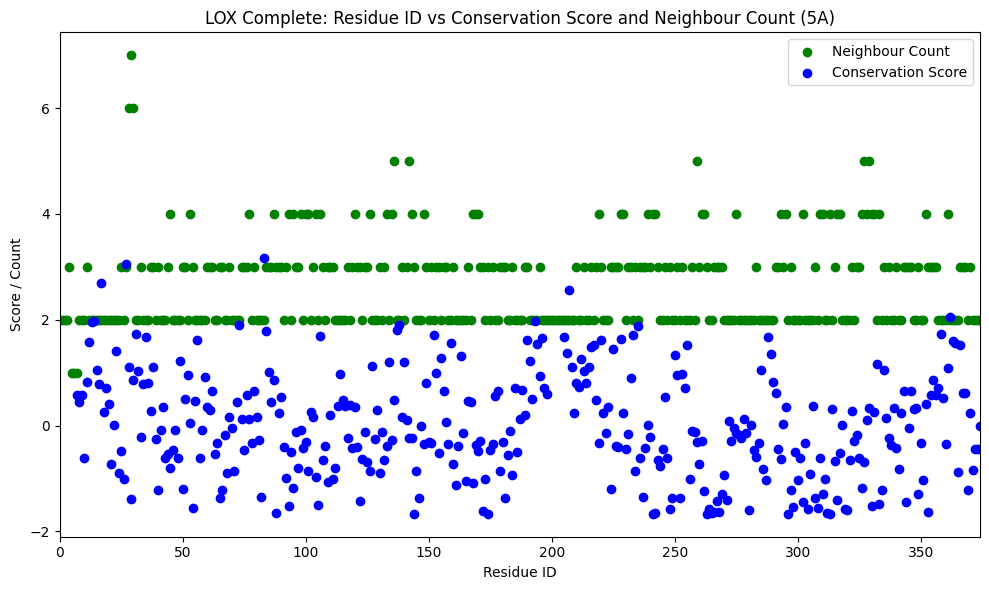

/var/folders/c1/vbqmbhrj0n3gff0pm_xnb7zc0000gn/T/ipykernel_92931/2454214137.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


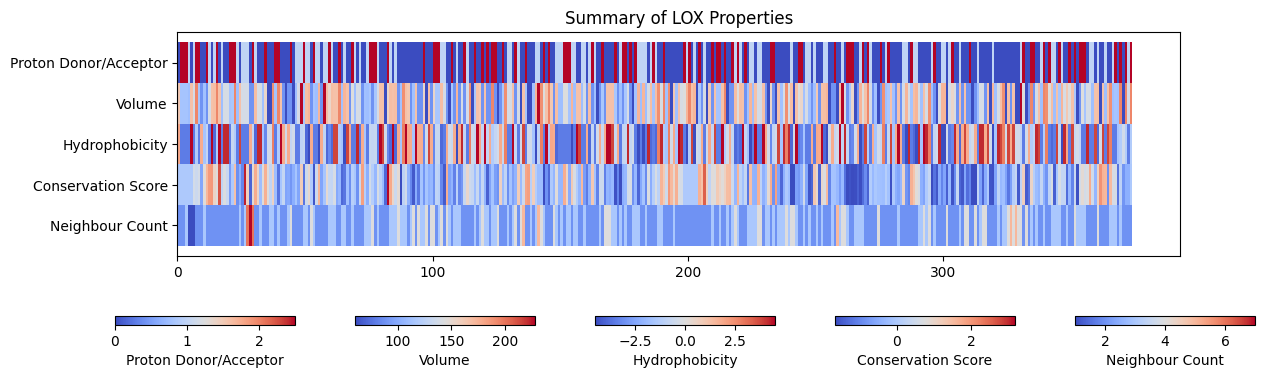

{(-2959, 'ILE'): 'pdb2du2_A, pdb2e77_A', (-2908, 'ALA'): 'pdb2du2_A, pdb2e77_A', (-2907, 'PRO'): 'pdb2du2_A, pdb2e77_A', (-2906, 'ILE'): 'pdb2du2_A, pdb2e77_A', (-2905, 'ALA'): 'pdb2du2_A, pdb2e77_A, pdb2e77_A', (-2878, 'SER'): 'pdb2du2_A, pdb2e77_A', (-2856, 'GLN'): 'pdb2du2_A, pdb2e77_A', (-2854, 'TYR'): 'pdb2du2_A, pdb2e77_A, pdb2e77_A', (-2828, 'THR'): 'pdb2du2_A, pdb2e77_A', (-2759, 'LYS'): 'pdb2du2_A, pdb2e77_A', (-2737, 'SER'): 'pdb2du2_A, pdb2e77_A', (-2735, 'HIS'): 'pdb2du2_A, pdb2e77_A, pdb2e77_A', (-2734, 'GLY'): 'pdb2du2_A, pdb2e77_A', (-2732, 'ARG'): 'pdb2du2_A, pdb2e77_A, pdb2e77_A', (-2704, 'ASP'): 'pdb2du2_A, pdb2e77_A', (-2703, 'SER'): 'pdb2du2_A, pdb2e77_A', (-2702, 'GLY'): 'pdb2du2_A, pdb2e77_A', (-2700, 'ARG'): 'pdb2du2_A, pdb2e77_A', (-2681, 'GLY'): 'pdb2du2_A, pdb2e77_A', (-2680, 'ARG'): 'pdb2du2_A, pdb2e77_A', (-2960, 'TYR'): 'pdb2e77_A', (-2876, 'TYR'): 'pdb2e77_A', (-2819, 'ARG'): 'pdb2e77_A', (-2785, 'TYR'): 'pdb2e77_A', (229, 'GLU'): 'pdb2j6x_D, pdb2j6x_E', (

Chain IDs for 2DU2: ['A', 'D', 'C', 'B']
Chain IDs for 2E77: ['A', 'D', 'C', 'B']
Chain IDs for 2J6X: ['D', 'E', 'C', 'F', 'H', 'B', 'A', 'G']
Chain IDs for 2NLI: ['A', 'B']
Chain IDs for 2ZFA: ['A', 'B']
Chain IDs for 4RJE: ['A', 'D', 'C', 'B']
Chain IDs for 4YL2: ['A', 'D', 'C', 'B']
Chain IDs for 5EBU: ['D', 'E', 'C', 'F', 'H', 'B', 'A', 'G']
Chain IDs for 7F1Y: ['A', 'B']
Chain IDs for 7F20: ['A', 'B']
Chain IDs for 7F21: ['A', 'B']
Chain IDs for 7F22: ['A', 'B']
Summary for 5EBU chain A saved successfully at LOX_outputs/LOX_conservation_scores/5EBUA_consurf_summary.txt.
Summary for 2NLI chain A saved successfully at LOX_outputs/LOX_conservation_scores/2NLIA_consurf_summary.txt.
Summary for 2J6X chain E saved successfully at LOX_outputs/LOX_conservation_scores/2J6XE_consurf_summary.txt.
Summary for 5EBU chain D saved successfully at LOX_outputs/LOX_conservation_scores/5EBUD_consurf_summary.txt.
Summary for 4RJE chain B saved successfully at LOX_outputs/LOX_conservation_scores/4RJEB

In [98]:
# Edit this
"""
Main Function

Vairables to Update:
- pdb_file_paths
- ref_seq
- protein_id
- num_residues
- weights
"""
pdb_file_paths = ['./NYLC_pdb/pdb5xyg.pdb', './NYLC_pdb/pdb5xyo.pdb', './NYLC_pdb/pdb5xyp.pdb', 
'./NYLC_pdb/pdb5xyq.pdb', './NYLC_pdb/pdb5xys.pdb', './NYLC_pdb/pdb5xyt.pdb', './NYLC_pdb/pdb5y0l.pdb', 
'./NYLC_pdb/pdb5y0m.pdb', './NYLC_pdb/pdb5yu0.pdb', './NYLC_pdb/pdb5yu1.pdb']

ref_seq = './NYLC_pdb/AF-QY9F77-F1-model_v4.pdb'
protein_id = 'NYLC'
molecular_name = 'ENDOTYPE 6-AMINOHEXANOAT-OLIGOMER HYDROLASE'
num_residues = 355

angstrom = 5
weights = [0.2,0.2,0.2,0.2,0.2]
download_conservation_scores(pdb_file_paths, protein_id, molecular_name)
align_pdb(ref_seq, pdb_file_paths, protein_id, molecular_name)

ref_seq = pdb_to_compiled_vector(ref_seq, angstrom, protein_id, molecular_name)
print(f"Ref Seq:{ref_seq}")

for pdb_file in pdb_file_paths:
        completed = pdb_to_compiled_vector(pdb_file, angstrom, protein_id, molecular_name)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed, angstrom)

print(f"Updated Seq: {updated_ref_seq}")

plot_and_calculate_correlation(updated_ref_seq, angstrom, protein_id, num_residues)
plot_residue_properties(updated_ref_seq, protein_id, num_residues)
binding_sites = extract_sites(pdb_file_paths)
print(binding_sites)
save_to_csv(updated_ref_seq, protein_id, binding_sites)
#analyse_protein(updated_ref_seq)
#analyse_protein_2(updated_ref_seq, weights, protein_id)
